In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.rc('figure', facecolor='w')
plt.rc('font', size=11)

METHODS = ['dft', 'emle_fixed', 'emle_flexible']
SYSTEMS = ['water', 'enzyme']

In [2]:
def read_data(filename):
    data = scipy.io.loadmat(filename, squeeze_me=True)
    return {k: v for k, v in data.items() if hasattr(v, 'shape')}


def merge_dicts(list_of_dicts):
    keys = list_of_dicts[0].keys()
    return {k: np.array([_[k] for _ in list_of_dicts]) for k in keys}

enzyme_data = merge_dicts([read_data(f'CHO/analyze/enzyme/{i}.mat') for i in range(1, 49)])
water_data = merge_dicts([read_data(f'CHO/analyze/water/{i}.mat') for i in range(1, 69)])

In [3]:
def get_rc(xyz):
    d1 = np.linalg.norm(xyz[:, :, 5] - xyz[:, :, 7], axis=-1)
    d2 = np.linalg.norm(xyz[:, :, 0] - xyz[:, :, 9], axis=-1)
    return d1 - d2

enzyme_data['rc'] = get_rc(enzyme_data['xyz'])
water_data['rc'] = get_rc(water_data['xyz'])

In [4]:
enzyme_range = (-2.6, 2.4)
water_range = (-4.6, 2.45)

enzyme_data['bins'] = np.arange(enzyme_range[0], enzyme_range[1] + 0.001, 0.05)
water_data['bins'] = np.arange(water_range[0], water_range[1] + 0.001, 0.05)

In [5]:
def read_pmf(system, method):
    return np.loadtxt(f'CHO/PMF/pmf_{system}_{method}.dat').T

def read_system_pmf(system):
    data_raw = np.array([read_pmf(system, method) for method in METHODS])
    rc = data_raw[0][0]
    pmfs_raw = data_raw[:,1,:]
    pmfs = pmfs_raw - np.min(pmfs_raw[:,:len(rc)//2], axis=1, keepdims=True)
    return {'rc': rc, **{method: pmf for method, pmf in zip(METHODS, pmfs)}}

pmf_enzyme = read_system_pmf('enzyme')
pmf_water = read_system_pmf('water')

In [6]:
def get_by_rc(rc, values, bins):
    y, x = np.histogram(rc, bins=bins)
    bin_centers = (x[1:] + x[:-1]) / 2
    nbins = len(y)
    bin_width = x[1] - x[0]
    bin_idx = ((rc - x[0]) // bin_width).astype(int)
    mean_by_rc = np.array([np.mean(values[bin_idx == i])
                             for i in range(nbins)])
    return bin_centers, mean_by_rc

In [7]:
from scipy.interpolate import make_smoothing_spline

def get_by_rc_smooth(rc, values):
    sorted_indices = np.argsort(rc.flatten())
    x = rc.flatten()[sorted_indices]
    y = values.flatten()[sorted_indices] 
    spl = make_smoothing_spline(x, y, lam=1)
    
    bin_centers = np.linspace(np.min(x), np.max(x), 100)
    return bin_centers, spl(bin_centers)

In [8]:
PALETTE = {'black': '#000000', 
           'grey': '#555555', 
           'blue': '#1f77b4', 
           'orange': '#ff7f0e', 
           'red': '#d62728',
           'green': '#2ca02c',
           'purple': '#9467bd',
           'pink': '#e377c2'}

PARAMS = {
    'dft': {'c': PALETTE['black'], 'label': 'DFT/MM'},
    'emle_flexible': {'c': PALETTE['red'], 'label': 'ML(EMLE)/MM (flexible $\\alpha/v$)'},
    'emle_fixed': {'c': PALETTE['orange'], 'label': 'ML(EMLE)/MM (fixed $\\alpha/v$)'},
    'mech': {'c': PALETTE['blue'], 'label': 'Mech. embedding', 'linestyle': '--'},
    'MM_R': {'c': PALETTE['green'], 'label': 'MM embedding ($q_{R}$)', 'linestyle': ':'},
    'MM_P': {'c': PALETTE['purple'], 'label': 'MM embedding ($q_{P}$)', 'linestyle': ':'},
    'total': {'c': PALETTE['black'], 'label': 'Total'},
    'gas': {'c': PALETTE['black'], 'label': 'Gas'},
    'static': {'c': PALETTE['blue'], 'label': 'Static'},
    'static_mbis': {'c': PALETTE['green'], 'label': 'Static (Exact MBIS)'},
    'induced_flexible': {'c': PALETTE['red'], 'label': 'Induced (flexible $\\alpha/v$)', 'linestyle': '--'},
    'induced_fixed': {'c': PALETTE['orange'], 'label': 'Induced (fixed $\\alpha/v$)', 'linestyle': '--'},
}

def plot_series(ax, x, y, name):
    y_smooth = make_smoothing_spline(x, y, lam=0.001)(x)
    ax.plot(x, y_smooth, **PARAMS[name])
    

def plot_errors(ax, data):
    err_vac = data['E_vac_emle'] - data['E_vac_qm']
    err_static = data['E_static_emle'] - data['E_static_qm']
    err_static_mbis = data['E_static_mbis'] - data['E_static_qm']
    err_induced_flexible = data['E_induced_emle_flexible'] - data['E_induced_qm']
    err_induced_fixed = data['E_induced_emle_fixed'] - data['E_induced_qm']

    x, err_vac_mean = get_by_rc(data['rc'], err_vac, data['bins'])
    x, err_static_mean = get_by_rc(data['rc'], err_static, data['bins'])
    x, err_static_mbis_mean = get_by_rc(data['rc'], err_static_mbis, data['bins'])
    x, err_induced_flexible_mean = get_by_rc(data['rc'], err_induced_flexible, data['bins'])
    x, err_induced_fixed_mean = get_by_rc(data['rc'], err_induced_fixed, data['bins'])

    plot_series(ax, x, err_vac_mean, 'gas')
    plot_series(ax, x, err_static_mean, 'static')
    plot_series(ax, x, err_induced_fixed_mean, 'induced_fixed')
    plot_series(ax, x, err_induced_flexible_mean, 'induced_flexible')


def plot_pmf(ax, data):
    ax.set_ylim([-20, 30])
    for method in METHODS:
        ax.plot(data['rc'], data[method], **PARAMS[method])


def filter_artists(artists):
    # To avoid warning
    return [a for a in artists if not a.get_label().startswith('_')]
    

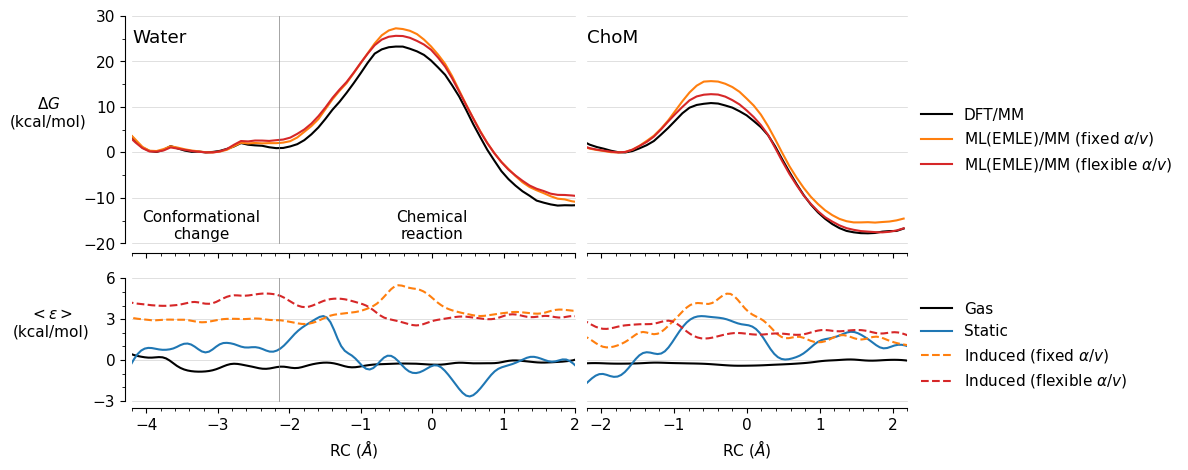

In [9]:
WATER_MIN = -4.2
WATER_MAX = 2
WATER_OFFSET = 0.1
WATER_STEP = 0.2

ENZYME_MIN = -2.2
ENZYME_MAX = 2.2
ENZYME_STEP = 0.2

PMF_MIN = -20
PMF_MAX = 30
PMF_OFFSET = 2
PMF_STEP = 5
PMF_TICKS = np.arange(PMF_MIN, PMF_MAX + 0.01, 10)

ERR_MIN = -3
ERR_MAX = 6
ERR_OFFSET = 0.5
ERR_STEP = 1
ERR_TICKS = np.arange(ERR_MIN, ERR_MAX + 0.01, 3)

fig, axs = plt.subplot_mosaic(
    [['pmf_water', 'pmf_enzyme'], ['err_water', 'err_enzyme']], 
    figsize=(10, 5), 
    gridspec_kw={'wspace': 0.03, 'hspace': 0.2, 'height_ratios': [0.65, 0.35], 'width_ratios': [0.58, 0.42]}
)
axs['err_water'].sharex(axs['pmf_water'])
axs['err_enzyme'].sharex(axs['pmf_enzyme'])
axs['pmf_enzyme'].sharey(axs['pmf_water'])
axs['err_enzyme'].sharey(axs['err_water'])

plot_pmf(axs['pmf_water'], pmf_water)
plot_pmf(axs['pmf_enzyme'], pmf_enzyme)

axs['pmf_water'].set_ylim([PMF_MIN, PMF_MAX])
axs['pmf_water'].set_yticks(PMF_TICKS)
axs['pmf_water'].yaxis.set_minor_locator(MultipleLocator(PMF_STEP))

axs['pmf_water'].set_ylabel('$\Delta G$\n(kcal/mol)', labelpad=25, rotation=0)
axs['pmf_water'].spines['top'].set_visible(False)
axs['pmf_water'].spines['left'].set_position(('data', WATER_MIN - WATER_OFFSET))
axs['pmf_water'].spines['bottom'].set_position(('data', PMF_MIN - PMF_OFFSET))
axs['pmf_water'].spines['right'].set_visible(False)
axs['pmf_water'].tick_params(labelbottom=False)

axs['pmf_enzyme'].spines['top'].set_visible(False)
axs['pmf_enzyme'].yaxis.set_visible(False)
axs['pmf_enzyme'].spines['left'].set_visible(False)
axs['pmf_enzyme'].spines['bottom'].set_position(('data', PMF_MIN - PMF_OFFSET))
axs['pmf_enzyme'].spines['right'].set_visible(False)
axs['pmf_enzyme'].tick_params(labelbottom=False)

plot_errors(axs['err_water'], water_data)
plot_errors(axs['err_enzyme'], enzyme_data)

axs['err_water'].set_xlim([WATER_MIN, WATER_MAX])
axs['err_water'].xaxis.set_minor_locator(MultipleLocator(WATER_STEP))
axs['err_water'].set_ylim([ERR_MIN, ERR_MAX])
axs['err_water'].set_yticks(ERR_TICKS)
axs['err_water'].yaxis.set_minor_locator(MultipleLocator(ERR_STEP))
axs['err_water'].spines['top'].set_visible(False)
axs['err_water'].spines['right'].set_visible(False)
axs['err_water'].spines['left'].set_position(('data', WATER_MIN - WATER_OFFSET))
axs['err_water'].spines['bottom'].set_position(('data', ERR_MIN - ERR_OFFSET))
axs['err_water'].set_xlabel('RC ($\AA$)')
axs['err_water'].set_ylabel('$<\epsilon>$\n(kcal/mol)', labelpad=30, rotation=0)

axs['err_enzyme'].set_xlim([ENZYME_MIN, ENZYME_MAX])
axs['err_enzyme'].xaxis.set_minor_locator(MultipleLocator(ENZYME_STEP))
axs['err_enzyme'].yaxis.set_visible(False)
axs['err_enzyme'].spines['top'].set_visible(False)
axs['err_enzyme'].spines['left'].set_visible(False)
axs['err_enzyme'].spines['bottom'].set_position(('data', ERR_MIN - ERR_OFFSET))
axs['err_enzyme'].spines['right'].set_visible(False)
axs['err_enzyme'].set_xlabel('RC ($\AA$)')

for system in SYSTEMS:
    for y in PMF_TICKS:
        axs[f'pmf_{system}'].axhline(y=y, color='lightgrey', linewidth=0.5, zorder=-1, clip_on=False)
    for y in ERR_TICKS:
        axs[f'err_{system}'].axhline(y=y, color='lightgrey', linewidth=0.5, zorder=-1, clip_on=False)

axs['pmf_water'].text(-4.2, 24, 'Water', ha='left', fontsize='large')
axs['pmf_enzyme'].text(-2.2, 24, 'ChoM', ha='left', fontsize='large')

axs['pmf_water'].text(-3.23, -19, 'Conformational\nchange', ha='center')
axs['pmf_water'].text(0., -19, 'Chemical\nreaction', ha='center')

axs['pmf_water'].axvline(x=-2.15, color='grey', linewidth=0.5, clip_on=False)
axs['err_water'].axvline(x=-2.15, color='grey', linewidth=0.5, clip_on=False)

fig.legend(handles=filter_artists(axs['pmf_water'].lines), frameon=False, 
           loc='center left', bbox_to_anchor=(0.9, 0.63))
fig.legend(handles=filter_artists(axs['err_water'].lines), frameon=False, 
           loc='center left', bbox_to_anchor=(0.9, 0.22))
plt.savefig('Fig4.png', dpi=300, bbox_inches='tight')
plt.show()